In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from functions import preprocessing

# 1/ Dataset upload/overview

In [2]:
df = pd.read_csv("data/kaya_dataset.csv")
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7745 entries, 0 to 7744
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   country              7745 non-null   object 
 1   year                 7745 non-null   int64  
 2   iso_code             7745 non-null   object 
 3   co2                  7745 non-null   float64
 4   energy               7745 non-null   float64
 5   gdp                  7745 non-null   float64
 6   population           7745 non-null   float64
 7   co2_per_unit_energy  7745 non-null   float64
 8   energy_per_gdp       7745 non-null   float64
 9   gdp_per_capita       7745 non-null   float64
dtypes: float64(7), int64(1), object(2)
memory usage: 605.2+ KB
None


,year,co2,energy,gdp,population,co2_per_unit_energy,energy_per_gdp,gdp_per_capita
count,7745.000000,7745.000000,7.745000e+03,7.745000e+03,7.745000e+03,7745.000000,7745.000000,7745.000000
mean,1997.914009,169.430360,7.407782e+11,4.259151e+11,4.002676e+07,0.239455,1.674191,13025.601709
std,15.104324,683.710379,2.786040e+12,1.488989e+12,1.350935e+08,0.200058,1.631089,14718.564983
min,1965.000000,0.022000,9.765923e+07,1.642060e+08,6.408200e+04,0.018000,0.078000,361.188725
25%,1986.000000,3.691000,1.850453e+10,1.803369e+10,3.593782e+06,0.186000,0.767000,2808.878751
50%,1999.000000,20.870000,8.890039e+10,6.434611e+10,9.754398e+06,0.221000,1.245000,7828.856656
75%,2011.000000,84.838000,4.128210e+11,2.542891e+11,2.810118e+07,0.261000,2.053000,18309.742796
max,2022.000000,11711.808000,4.451869e+13,2.696602e+13,1.426437e+09,10.689000,25.253000,163531.400281


# 2/ data and feature selection

In [3]:
# countries selection :
countries = df.country.unique()
# year selection :
years = df.year.unique()
# years = [2022]  # only 2022
# features selection :
cols = df.columns.tolist()

# 3/ Preprocessing

In [4]:
def log_transform(df:pd.DataFrame, years:list, countries:list, cols:list) -> pd.DataFrame:
    """ select data and features to process and log-transform floats"""
    dfl = df.copy()
    dfl = dfl[dfl['year'].isin(years)]
    dfl = dfl[dfl['country'].isin(countries)]
    dfl = dfl[cols]
    dfl.reset_index(drop=True, inplace=True)
    
    # columns to log-transform (floats) :
    features = dfl.select_dtypes(include=['float64']).columns.tolist()
    # floats = dfl.dtypes[df.dtypes == 'float64'].index.tolist() # same result

    # log transform because asyetrical distributions
    for col in features:
        dfl[col] = np.log1p(dfl[col])  # log1p to handle zero values safely 
    return dfl

# test preprocessing: 
# dfl = preprocessing(df, years, countries, cols)
# print(df.describe())
# dfl.head()


# 4/ Analysis

### univariate analysis

In [5]:
def mono_analysis(df:pd.DataFrame, features:list, title:str, log=False):
   """ display distribution chart (barplot) for each feature"""
   
   colorList = ["#3A3533", '#E15759', '#F28E2B', '#76B7B2', '#59A14F', '#EDC948', '#B07AA1', '#FF9DA7', "#3A3533", '#BAB0AC']
   
   fig, ax = plt.subplots(2, 4, squeeze=True, figsize=(15,4), gridspec_kw={'height_ratios':[3,1]} )
   fig.suptitle(f"ANALYSE MONOVARIEE VARIABLES CONTINUES - {title}")
   for i, v in enumerate(features):
      df[v].plot(
         ax=ax[0, i], 
         kind='hist', 
         bins=40, 
         color=colorList[i],
         edgecolor='black',
         title=v)
      ax[0, i].set(xlabel=None, xticklabels=[])
      
      # log scale (optional)
      if log:
         ax[0,i].set_yscale('log')  
         
      if i>0:
         ax[0, i].set(ylabel=None)

   for i, v in enumerate(features):
      df[v].plot(
         ax=ax[1, i], 
         kind='box', 
         vert=False,
         color='grey',
         )
      ax[1, i].set(ylabel=None, yticklabels=[])
   fig.tight_layout()
   return fig, ax


### multivariate analysis

In [6]:
def multi_analysis(df:pd.DataFrame, features:list, title:str, log=False):
    """ display all scatterplots between 2 features out of a list of features"""
    sns.set(font_scale=0.6)
    fig, ax = plt.subplots(len(features), len(features), figsize=(15,15))
    fig.suptitle(f"ANALYSES MULTIVARIEE CONTINUE/CONTINUE 2 à 2\nNuages de points {title}")

    for i, v in enumerate(features):
            
        for j, w in enumerate(features):       
            sns.scatterplot(
                ax=ax[i, j], 
                data=df, 
                x=w,
                y=v,
                hue='country',
                palette='Set1',   
                alpha=0.9,  
                # legend = i+j==0,
                legend = False,
                s=10,
                )
            
            # log scale (optional)
            if log:
                ax[i, j].set(xscale='log', yscale='log')
            
            if i!=0 and i!= len(features)-1:
                ax[i,j].set(xlabel=None, xticklabels=[])
            if j !=0 and j!= len(features)-1:
                ax[i,j].set(ylabel=None, yticklabels=[])
                
            if i == 0:
                ax[i,j].xaxis.tick_top()
                ax[i,j].xaxis.set_label_position('top')
            if i == len(features)-1:
                ax[i,j].xaxis.tick_bottom()
                ax[i,j].xaxis.set_label_position('bottom')
                
            if j == 0:
                ax[i,j].yaxis.tick_left()
                ax[i,j].yaxis.set_label_position('left')
            if j == len(features)-1:
                ax[i,j].yaxis.tick_right()
                ax[i,j].yaxis.set_label_position('right')
    return fig, ax

### Pearson analysis

In [7]:
def pearson_analysis(dfl, features):
    """display Pearson correlation between 2 features, for all features"""
    print("Pearson Analysis between 2 features :")
    print("\t 1: dependance\n\t 0: independance\n\t-1: negative dependance")
    print()
    for ix, feature_1 in enumerate(features):
        for iy, feature_2 in enumerate(features[ix + 1:]):
            print(f"{feature_1:.<20} / {feature_2:.<20} : {pearsonr(dfl[feature_1], dfl[feature_2]).statistic:.2f}")
            # print(f"{feature_1} / {feature_2} : ")
            
            
# test :
dfl = log_transform(df, years, countries, cols)
features = dfl.select_dtypes(include=['float64']).columns.tolist()

pearson_analysis(dfl, features)

Pearson Analysis between 2 features :
	 1: dependance
	 0: independance
	-1: negative dependance

co2................. / energy.............. : 0.97
co2................. / gdp................. : 0.93
co2................. / population.......... : 0.68
co2................. / co2_per_unit_energy. : 0.02
co2................. / energy_per_gdp...... : 0.43
co2................. / gdp_per_capita...... : 0.59
energy.............. / gdp................. : 0.94
energy.............. / population.......... : 0.67
energy.............. / co2_per_unit_energy. : -0.13
energy.............. / energy_per_gdp...... : 0.46
energy.............. / gdp_per_capita...... : 0.63
gdp................. / population.......... : 0.81
gdp................. / co2_per_unit_energy. : -0.09
gdp................. / energy_per_gdp...... : 0.15
gdp................. / gdp_per_capita...... : 0.52
population.......... / co2_per_unit_energy. : -0.01
population.......... / energy_per_gdp...... : -0.12
population.......... / gdp_per_

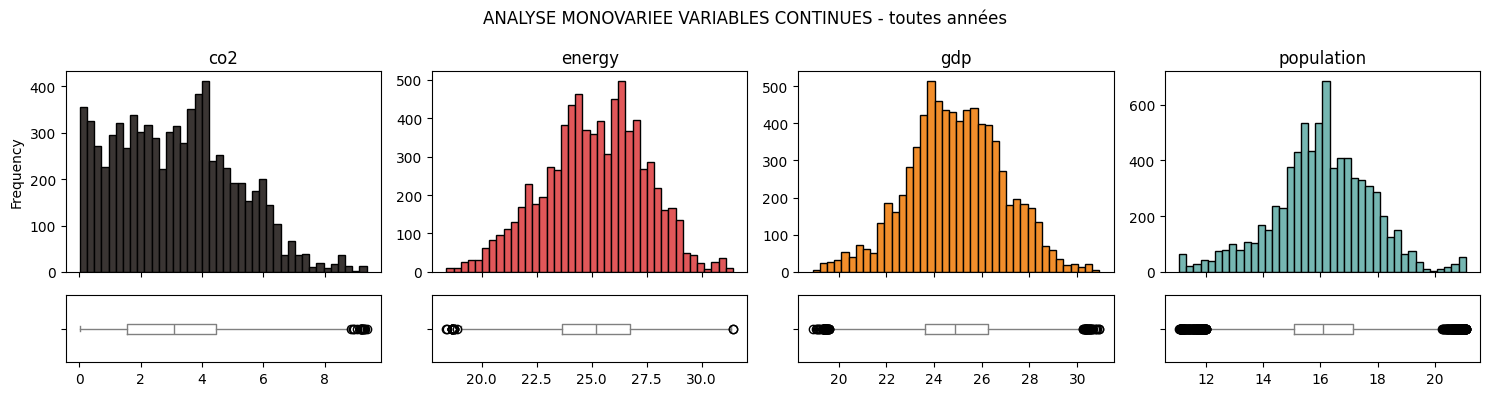

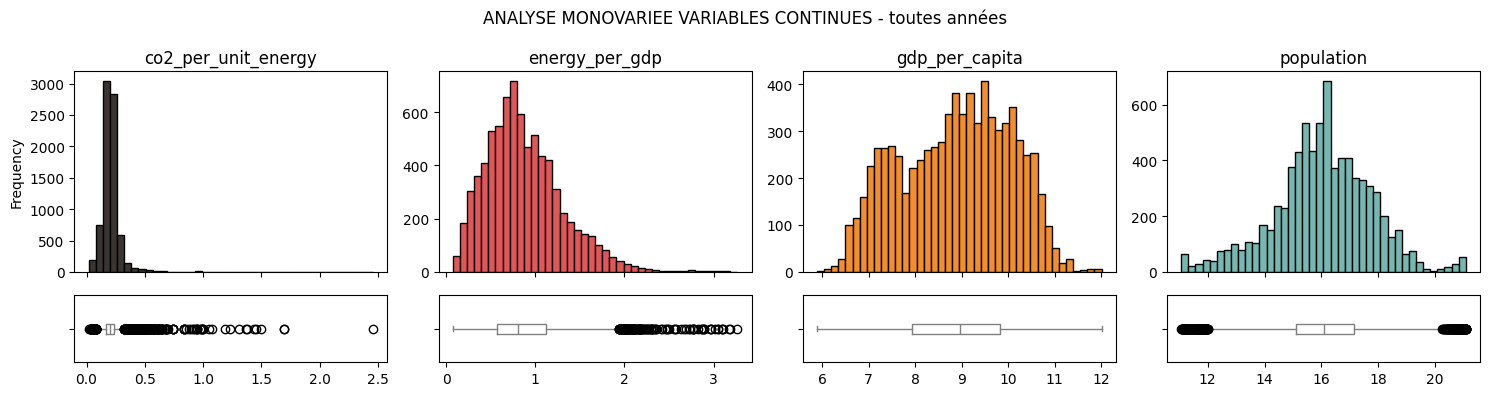

In [14]:
fig, ax = mono_analysis(dfl, ['co2', 'energy', 'gdp', 'population'], "toutes années")
fig, ax = mono_analysis(dfl, ['co2_per_unit_energy', 'energy_per_gdp', 'gdp_per_capita', 'population'], "toutes années")

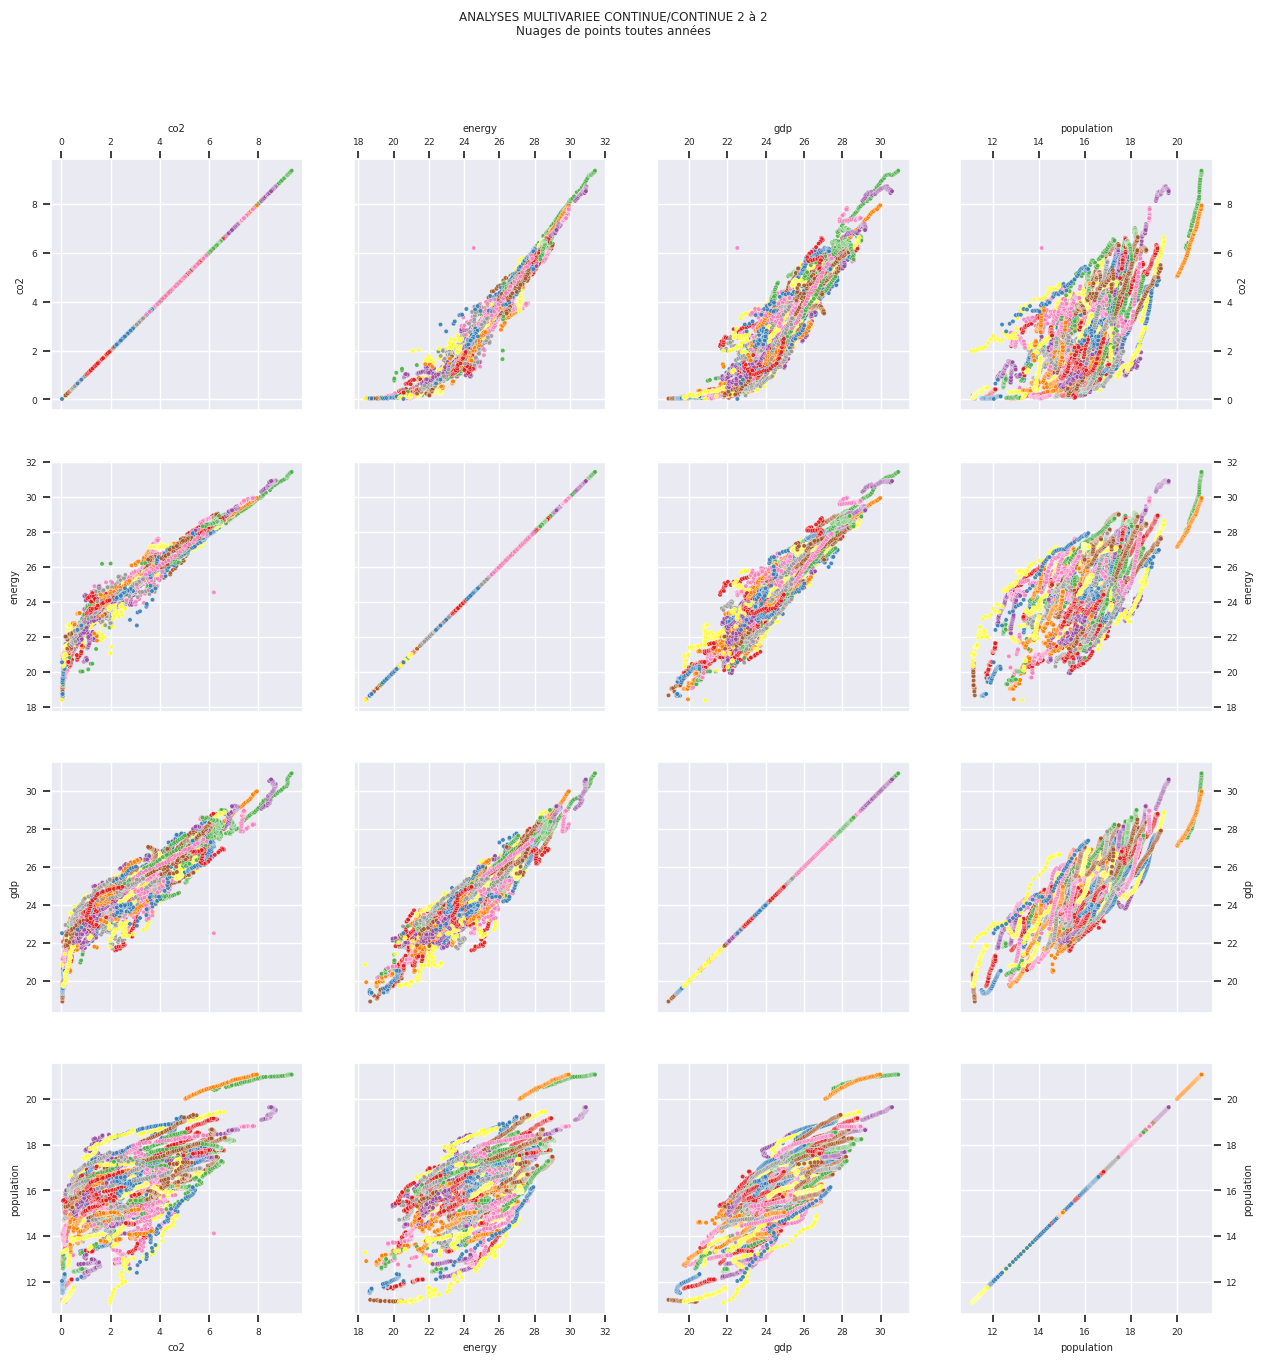

In [15]:
fig, ax = multi_analysis(dfl, ['co2', 'energy', 'gdp', 'population'], "toutes années")  

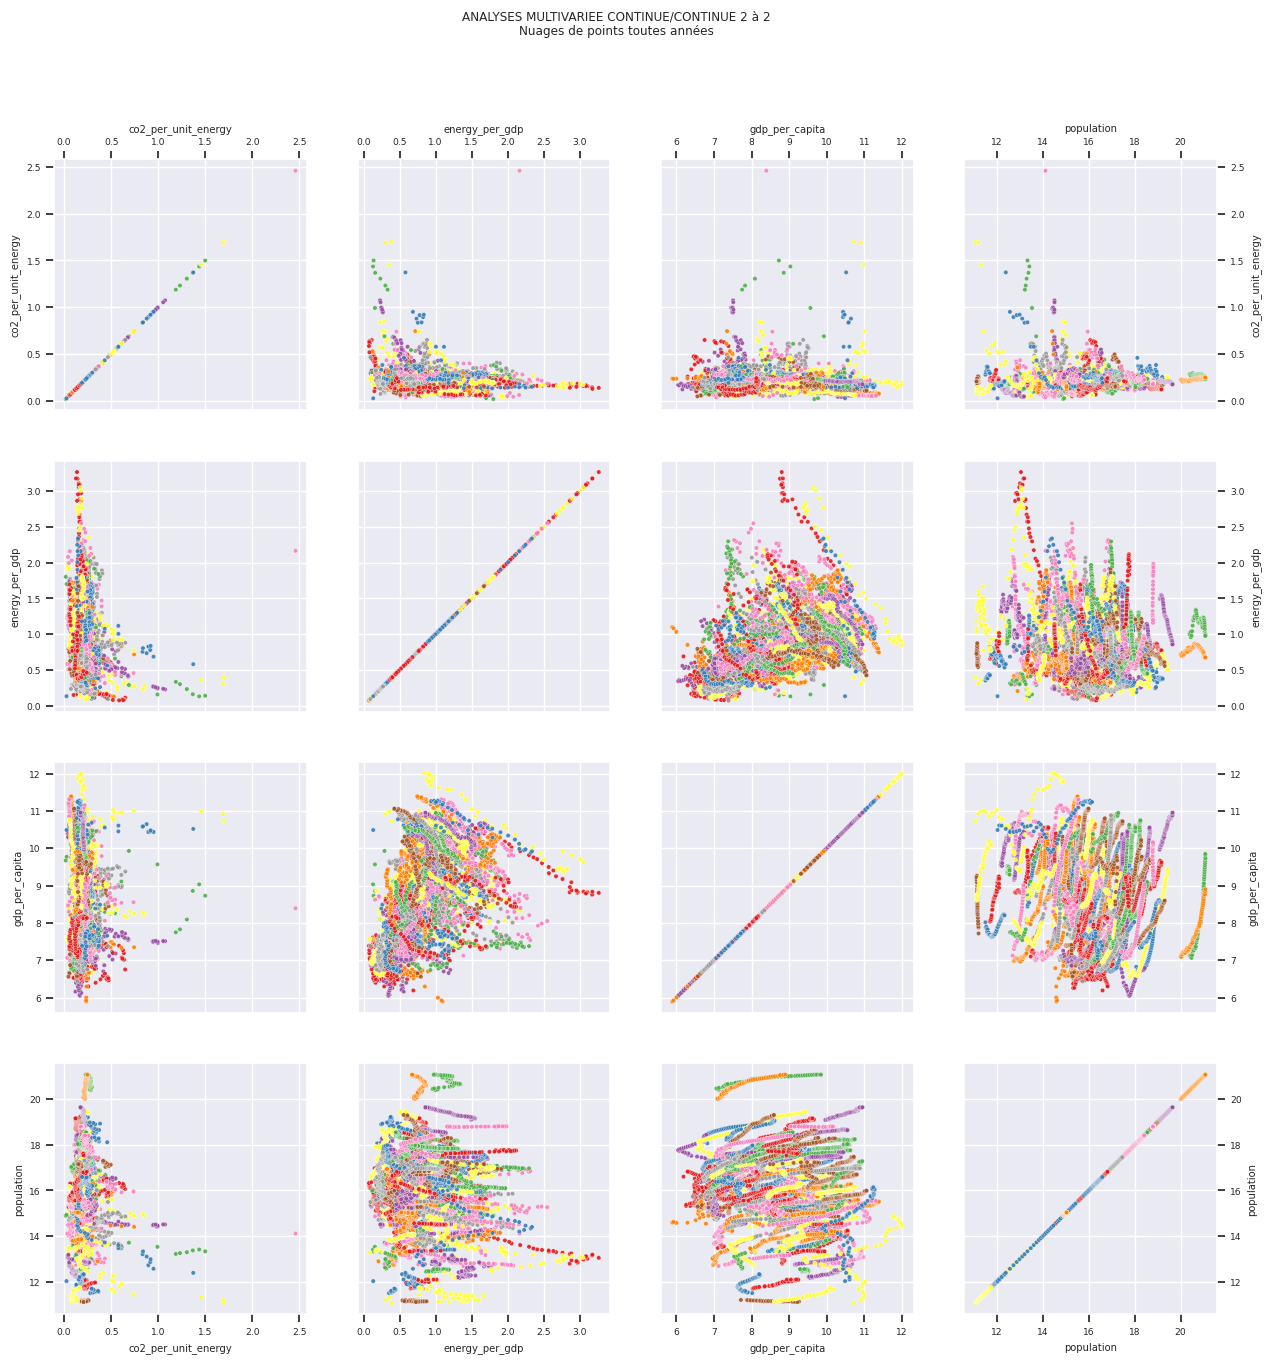

In [16]:
fig, ax = multi_analysis(dfl, ['co2_per_unit_energy', 'energy_per_gdp', 'gdp_per_capita', 'population'], "toutes années")

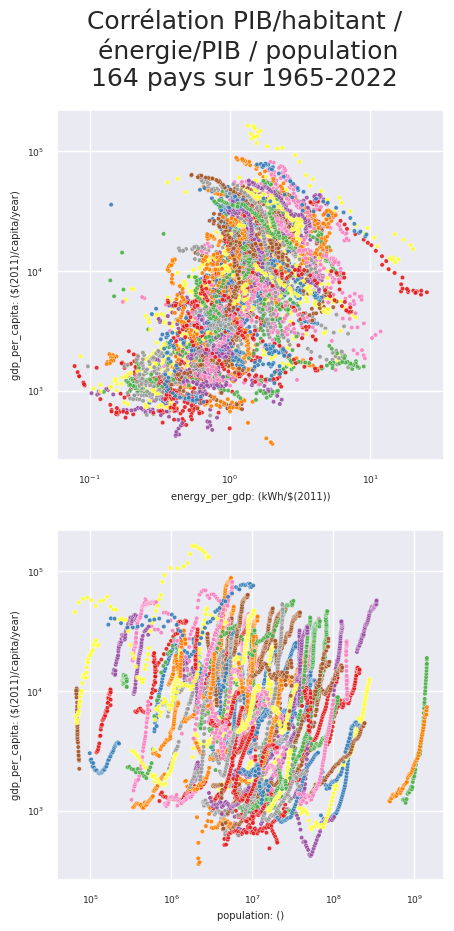

In [13]:
def multi_analysis_2(df:pd.DataFrame, features:list, units:dict, title:str, log=False):
    """ display 1 vertical subplot of 2 scatterplots between 2 features out of a list of features"""
    sns.set(font_scale=0.6)
    fig, ax = plt.subplots(len(features)-1, 1, figsize=(5,10), squeeze=False)
    # fig, ax = plt.subplots(1, figsize=(5,5), squeeze=False)
    fig.suptitle(title, fontsize=18)
    
    
    for i in range(len(features)-1):
        sns.scatterplot(
            ax=ax[i, 0], 
            data=df, 
            x=df[features[i+1]],
            y=df[features[0]],
            hue='country',
            palette='Set1',   
            alpha=0.9,  
            # legend = i+j==0,
            legend = False,
            s=10,
            )
        if log:
            ax[i, 0].set(xscale='log', yscale='log')
        ax[i,0].set(xlabel=f"{features[i+1]}: ({units[features[i+1]]})")
        ax[i,0].set(ylabel=f"{features[0]}: ({units[features[0]]})")
    return fig, ax

fig = multi_analysis_2(
    df, 
    ['gdp_per_capita', 'energy_per_gdp', 'population'],
    {'gdp_per_capita': '$(2011)/capita/year', 'energy_per_gdp': 'kWh/$(2011)', 'population': ''}, 
    f"Corrélation PIB/habitant /\n énergie/PIB / population\n{len(set(df['country']))} pays sur {min(set(df['year']))}-{max(set(df['year']))}",
    log=True)

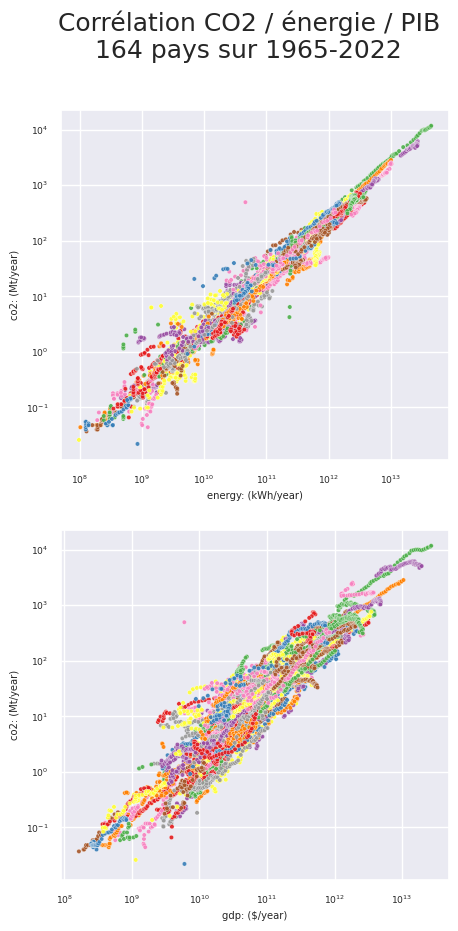

In [11]:
fig = multi_analysis_2(
    df, 
    ['co2', 'energy', 'gdp'],
    {'co2': 'Mt/year', 'energy': 'kWh/year', 'gdp': '$/year'}, 
    f"Corrélation CO2 / énergie / PIB\n{len(set(df['country']))} pays sur {min(set(df['year']))}-{max(set(df['year']))}",
    log=True)

# 5/ Conclusion

### Pearson analysis :
- CO2 emissions, energy consumption and gdp are highly correlated (> 90%)
- ...


# Ressources :
- https://ourworldindata.org/worlds-energy-problem
- recherche : https://www.kaggle.com/search?q=co2+emission+per+country
dont :
- https://www.kaggle.com/code/sasakitetsuya/co2-emission-gap-among-countries-clustering-pca
- https://www.kaggle.com/code/catamount11/who-is-responsible-for-global-warming

